In [1]:
import sys
sys.path.append('../')

import numpy as np
import legume

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

## Reproduce Fig. 10 in Chapter 5 of "Photonic Crystals: Molding the Flow of Light"

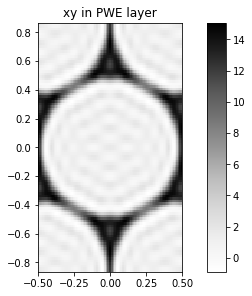

In [2]:
# Initialize a lattice
lattice = legume.Lattice('hexagonal')
# Initialize a layer
layer = legume.ShapesLayer(lattice, eps_b = 13)
# Add a shape to this layer 
circle = legume.Circle(r=0.48)
layer.add_shape(circle)

# Initialize the PWE 
pwe = legume.PlaneWaveExp(layer, gmax=5)
pwe.plot_overview_ft()

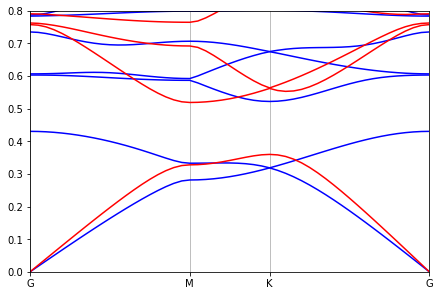

In [3]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm, 'b')
plt.plot(freqs_te, 'r')
ax.set_ylim([0, 0.8])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Optimize the band gap with a supercell and autograd

In [4]:
import autograd.numpy as npa
from autograd import grad
legume.set_backend('autograd')

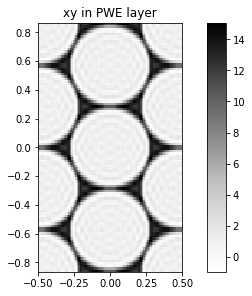

In [7]:
def pwe_3hole(rs, gmax=10):
    # Make a PWE simulation with 3 holes in the elementary cell
    # Initialize a lattice
    lattice = legume.Lattice('hexagonal')
    # Initialize a layer
    layer = legume.ShapesLayer(lattice, eps_b = 13)
    a_sc = np.sqrt(3)
    # Make a supercell 
    circle1 = legume.Circle(r=rs[0]/a_sc)
    circle2 = legume.Circle(x_cent=np.sqrt(3)/2/a_sc, y_cent=0.5/a_sc, r=rs[1]/a_sc)
    circle3 = legume.Circle(x_cent=np.sqrt(3)/2/a_sc, y_cent=-0.5/a_sc, r=rs[2]/a_sc)
    layer.add_shape(circle1, circle2, circle3)
    
    return legume.PlaneWaveExp(layer, gmax=gmax)

# Initialize the PWE that should match the simulation above
pwe = pwe_3hole(0.48*npa.ones(3))
pwe.plot_overview_ft()

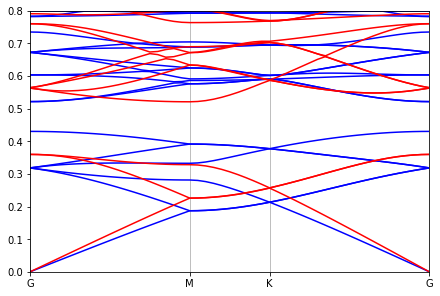

In [8]:
# Let's check that we get the same band gap despite the folded bands

path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/np.sqrt(3), 'b')
plt.plot(freqs_te/np.sqrt(3), 'r')
ax.set_ylim([0, 0.8])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

In [9]:
# Function to return the band-gap size around a given center frequency
def bg_size(freqs_te, freqs_tm, freq_cent = 0.48):
    freqs_all = npa.hstack((freqs_te.flatten(), freqs_tm.flatten()))
    freq_min = npa.amax(npa.where(freqs_all < freq_cent, freqs_all, 0))
    freq_max = npa.amin(npa.where(freqs_all > freq_cent, freqs_all, 1e6))
    return freq_max - freq_min

print('Band gap size:', bg_size(freqs_te/np.sqrt(3), freqs_tm/np.sqrt(3))) # the sqrt(3) is because of the different lattice constant

Band gap size: 0.0907610016955433


In [10]:
# Now make the radii of the 3 holes free parameters

def of_bg(rs):
    # Initialize the PWE 
    pwe = pwe_3hole(rs)

    # Run the PWE for both polarizations
    pwe.run(kpoints=path.kpoints, pol='te')
    freqs_te = pwe.freqs/np.sqrt(3)
    pwe.run(kpoints=path.kpoints, pol='tm')
    freqs_tm = pwe.freqs/np.sqrt(3)
    
    # And return the band gap size as objective function
    # We sample several different center frequencies and take the largest bandgap found
    cfs = npa.arange(0.4, 0.6, 0.05)
    bgs = []
    for cf in cfs:
        bg = bg_size(freqs_te, freqs_tm, freq_cent=cf)
        bgs.append(bg)

    return npa.amax(npa.array(bgs))

In [11]:
# Let's first test the gradient
from legume.utils import grad_num
grad_test = grad(of_bg)

print('Autograd gradient:  ', grad_test(0.48*npa.ones(3)))
print('Numerical gradient: ', grad_num(of_bg, 0.48*npa.ones(3)))

Autograd gradient:   [-0.37437648 -0.37437648 -0.37437648]
Numerical gradient:  [-0.37437704 -0.37437696 -0.37437707]


In [12]:
from legume.optimizers import adam_optimize

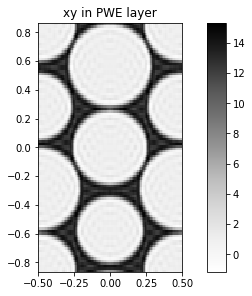

In [13]:
# Pick some starting point and show what the supercell is about
r_start = npa.array([0.45, 0.4, 0.5])
pwe = pwe_3hole(r_start)
pwe.plot_overview_ft()

In [15]:
# Run the optimization
(r_opt, ofs) = adam_optimize(of_bg, r_start, grad_test, step_size = 1e-3, Nsteps = 50, 
                             options = {'direction': 'max', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.03541638564357402
Parameters are:       [ 0.4500  0.4000  0.5000]
At iteration 1 :
Objective value is:   0.037029565935170206
Parameters are:       [ 0.4510  0.4010  0.5010]
At iteration 2 :
Objective value is:   0.03866807144217327
Parameters are:       [ 0.4520  0.4020  0.5020]
At iteration 3 :
Objective value is:   0.04033035181915151
Parameters are:       [ 0.4530  0.4030  0.5030]
At iteration 4 :
Objective value is:   0.04201380648190489
Parameters are:       [ 0.4540  0.4040  0.5040]
At iteration 5 :
Objective value is:   0.04371432519934437
Parameters are:       [ 0.4550  0.4050  0.5050]
At iteration 6 :
Objective value is:   0.04542565497752793
Parameters are:       [ 0.4560  0.4060  0.5060]
At iteration 7 :
Objective value is:   0.047138594946321
Parameters are:       [ 0.4570  0.4070  0.5070]
At iteration 8 :
Objective value is:   0.04884015768303562
Parameters are:       [ 0.4580  0.4080  0.5080]
At iteration 9 :
Objective value is:  

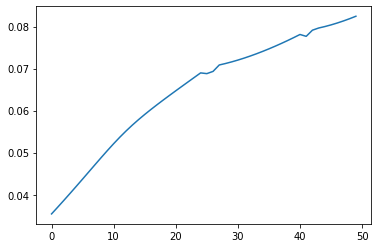

In [16]:
import matplotlib.pyplot as plt
plt.plot(ofs)
plt.show()

## Conclusion: 
- the starting structure is actually already really good (bg = 0.0907).
- the optimization here is approaching an unphysical structure cause the way things are defined right now holes shouldn't overlap...

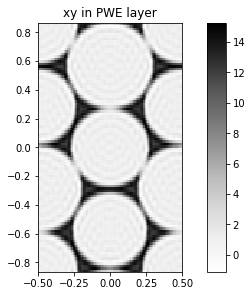

In [17]:
pwe = pwe_3hole(r_opt)
pwe.plot_overview_ft()